# Experiment with different classification algorithms

## Plan

Test the results with a simplified version of the survey in which we dont have X6 - App usability.

## Set up

In [39]:
import pandas as pd
import joblib
from IPython.display import display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.tree import ExtraTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.linear_model import Perceptron
from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectFromModel, chi2

# Load the data
file_path = r"../data/clean/ACME-happinesSurvey2020.parquet"
use_columns = ["X1", "X3", "Y"]
target = 'Y'
max_features = 8 if len(use_columns) < 4 else 10
data = pd.read_parquet(file_path, columns = use_columns)
data_melt = data.melt(id_vars=target, value_vars=data.columns)

## 1. Visualisualization of relationship between features and target

### 2.1 Plot correlations

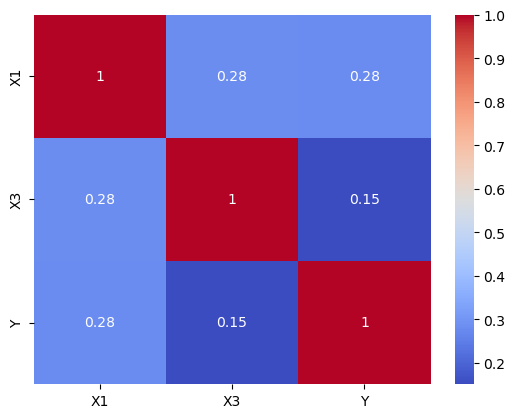

In [40]:
corr = data.corr()  # Calculate the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm')  # Create a heatmap
plt.show()  # Show the plot

### 2.2 Plot relationships

C:\Users\Guill\AppData\Local\Temp\ipykernel_107432\2225255784.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(


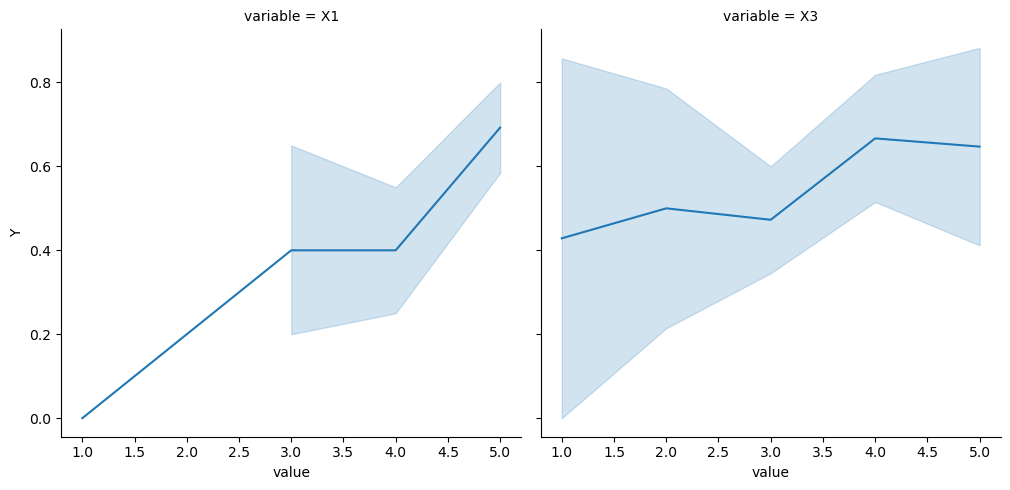

In [41]:
sns.relplot(
    x="value", y=target, col="variable", data=data_melt, facet_kws=dict(sharex=False),
    kind="line", palette="viridis", height=5, aspect=1,
    col_wrap=3

);

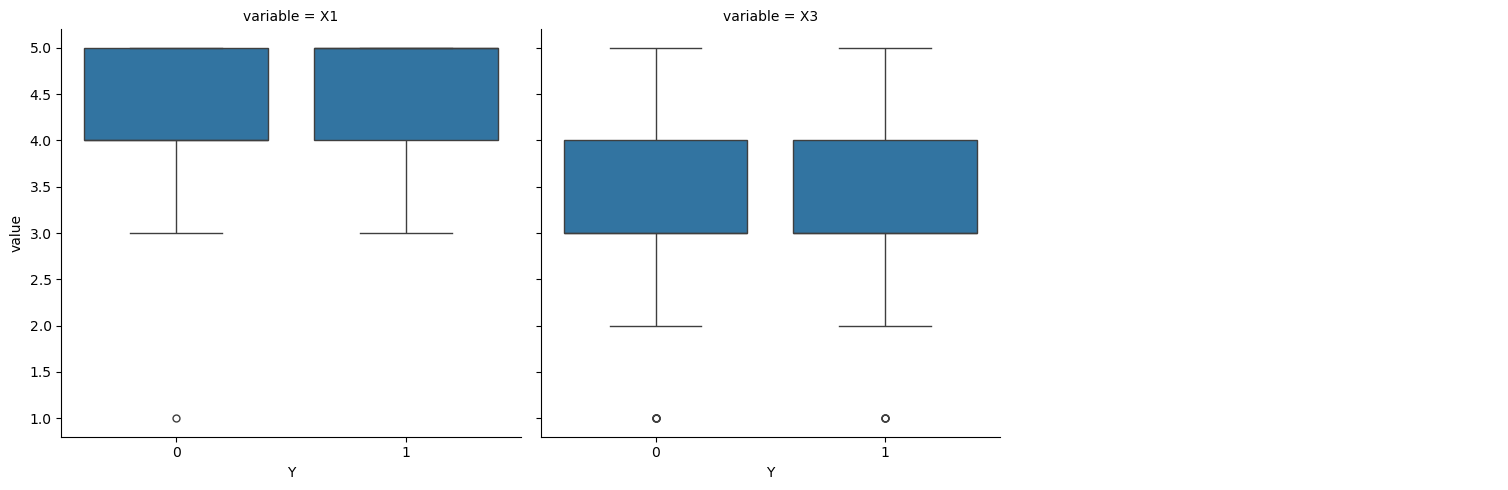

In [42]:
sns.catplot(x=target, y="value", col='variable', data=data_melt, kind="box", col_wrap=3);

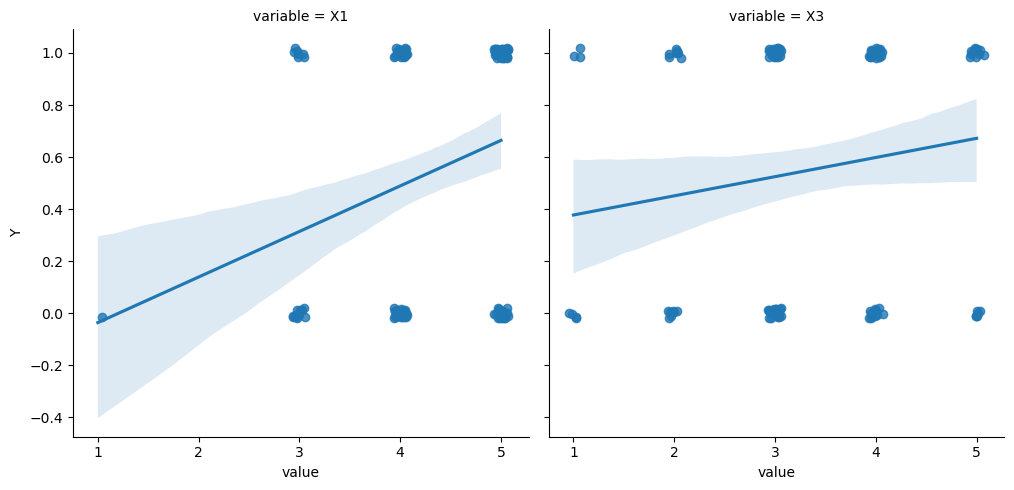

In [43]:
sns.lmplot(y=target, x="value", data=data_melt,
           col='variable', col_wrap=3,
           x_jitter=.07, y_jitter=.02, seed=42);

## 3. Modeling

#### 3.1 Split Data

In [44]:
# Separate features and target
y = data.pop('Y')
X = data

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.2 Baseline experiment with Different Classification Algorithms

#### 3.2.1 Baseline models

In [45]:
# Define the models
models = {
    'ExtraTreeClassifier': ExtraTreeClassifier(random_state=42),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'LabelSpreading': LabelSpreading(),
    'LabelPropagation': LabelPropagation(),
    'Perceptron': Perceptron(random_state=42)
}

# Define the parameter grids for each model
param_grids = {
    'ExtraTreeClassifier': {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'QuadraticDiscriminantAnalysis': {
        'reg_param': [0.0, 0.1, 0.5, 1.0],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1]
    },
    'LabelSpreading': {
        'kernel': ['knn', 'rbf'],
        'gamma': [0.1, 0.5, 1, 5],
        'n_neighbors': [3, 5, 7, 9]
    },
    'LabelPropagation': {
        'kernel': ['knn', 'rbf'],
        'gamma': [0.1, 0.5, 1, 5],
        'n_neighbors': [3, 5, 7, 9]
    },
    'Perceptron': {
        'penalty': [None, 'l2', 'l1', 'elasticnet'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'max_iter': [1000, 2000, 5000],
        'tol': [1e-4, 1e-3, 1e-2]
    }
}

# Define the scoring criteria
scoring = {'F1': make_scorer(f1_score), 'Recall': make_scorer(recall_score)}

# Perform hyperparameter tuning using RandomizedSearchCV for faster results
best_estimators = {}
best_scores = {}

for model_name, model in models.items():
    param_grid = param_grids[model_name]
    search = RandomizedSearchCV(model, param_grid, scoring=scoring, refit='F1', n_jobs=-1, cv=5, random_state=42)
    search.fit(X_train, y_train)
    
    # Store the best estimator and best scores
    best_estimators[model_name] = search.best_estimator_
    best_scores[model_name] = search.best_score_

best_estimators, best_scores

({'ExtraTreeClassifier': ExtraTreeClassifier(criterion='log_loss', max_depth=30, min_samples_leaf=2,
                      random_state=42),
  'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(reg_param=0.1, tol=0.001),
  'LabelSpreading': LabelSpreading(gamma=5, n_neighbors=5),
  'LabelPropagation': LabelPropagation(gamma=5, n_neighbors=5),
  'Perceptron': Perceptron(alpha=0.001, max_iter=5000, penalty='l2', random_state=42, tol=0.01)},
 {'ExtraTreeClassifier': 0.7534188034188034,
  'QuadraticDiscriminantAnalysis': 0.7266096866096866,
  'LabelSpreading': 0.7732625994694962,
  'LabelPropagation': 0.7732625994694962,
  'Perceptron': 0.6088709677419356})

### 3.3 Feature Engineering

#### 3.3.1  Feature Importances

In [46]:
# Initialize a dictionary to store feature importances using permutation importance
feature_importances = {}

# Loop through the best estimators
for model_name, model in best_estimators.items():
    if hasattr(model, 'feature_importances_'):
        # If the model has a feature_importances_ attribute
        feature_importances[model_name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # If the model has a coef_ attribute (for linear models)
        feature_importances[model_name] = model.coef_.flatten()
    else:
        print("Model does not have a feature_importances_ or coef_ attribute:", model_name)


# Convert the dictionary to a DataFrame
feature_importances_df = pd.DataFrame(feature_importances, index=X_train.columns)

# Display the DataFrame
feature_importances_df

Model does not have a feature_importances_ or coef_ attribute: QuadraticDiscriminantAnalysis
Model does not have a feature_importances_ or coef_ attribute: LabelSpreading
Model does not have a feature_importances_ or coef_ attribute: LabelPropagation


,ExtraTreeClassifier,Perceptron
X1,0.542875,8.582226
X3,0.457125,0.823426


In [47]:
# Initialize a dictionary to store feature importances using permutation importance
feature_importances_permutation = {}

# Loop through the best estimators
for model_name, model in best_estimators.items():
        # Calculate permutation importance
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        feature_importances_permutation[model_name] = result.importances_mean

        # Convert the dictionary to a DataFrame
        feature_importances_permutation_df = pd.DataFrame(feature_importances_permutation, index=X_train.columns)

# Display the DataFrame
feature_importances_permutation_df

,ExtraTreeClassifier,QuadraticDiscriminantAnalysis,LabelSpreading,LabelPropagation,Perceptron
X1,0.053846,-0.061538,0.103846,0.103846,0.0
X3,-0.042308,0.000000,-0.019231,-0.019231,0.0


### Permutation importance Interpretation:

- **X1** stands out as the most important feature overall, with a positive contribution, particularly in tree-based models.
- **X2** and **X6** seem to have a negative impact across the models, indicating that they might not be as useful and could potentially be candidates for removal or further investigation.
- **X3** and **X5** have minor positive impacts, but their overall influence is relatively low compared to X1.
- **X4** seems to have a negligible impact overall, with a slight negative influence.

> **Negative Coefficient** (in models like Logistic Regression or SVM): Indicates a negative effect on the target variable.
>
> **Negative Importance** (especially in permutation importance): Could indicate the feature is harmful or irrelevant to the model’s performance.

### 4: Feature Engineering: Create interaction features

In [48]:
# Feature Engineering: Create interaction features
poly = PolynomialFeatures(3, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
column_names_poly=poly.get_feature_names_out(X_train.columns)

# Train and evaluate each model with interaction features
results_poly = {}
for name, model in models.items():
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results_poly[name] = (accuracy, report)

# Print results for models with interaction features
for model_name, (accuracy, report) in results_poly.items():
    print(f"Model with Interaction Features: {model_name}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    print("="*60)

Model with Interaction Features: ExtraTreeClassifier
Accuracy: 0.5384615384615384
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.33      0.45        15
           1       0.47      0.82      0.60        11

    accuracy                           0.54        26
   macro avg       0.59      0.58      0.53        26
weighted avg       0.61      0.54      0.52        26

Model with Interaction Features: QuadraticDiscriminantAnalysis
Accuracy: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.27      0.38        15
           1       0.45      0.82      0.58        11

    accuracy                           0.50        26
   macro avg       0.56      0.54      0.48        26
weighted avg       0.57      0.50      0.47        26

Model with Interaction Features: LabelSpreading
Accuracy: 0.5769230769230769
Classification Report:
              precision    recall  f1-sco

c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\metrics\_classification.py:1531: Undefine

## 5: Feature Selection

#### 5.1 Permutation feature importance with interactions

In [49]:
# Initialize a dictionary to store the permutation importance
permutation_importances_poly = {}

# Loop through each model and calculate permutation importance
for model_name, model in models.items():
    # Calculate the permutation importance
    result = permutation_importance(
        model, X_test_poly, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    
    # Store the importance in the dictionary
    permutation_importances_poly[model_name] = result.importances_mean

# Create a DataFrame to organize and display the results
permutation_importances_poly_df = pd.DataFrame(permutation_importances_poly, index=column_names_poly)

# Reorder the columns to match the desired order
permutation_importances_poly_df = permutation_importances_poly_df[[
    'ExtraTreeClassifier', 'QuadraticDiscriminantAnalysis', 'LabelSpreading', 'LabelPropagation', 'Perceptron'
]]

# Add the sum and average of the importances across models
permutation_importances_poly_df = permutation_importances_poly_df.assign(
    sum_tree=lambda x: x.iloc[:, 2:4].sum(axis=1),  # Sum of tree-based models (RandomForest and GradientBoosting)
    avg_tree=lambda x: x.iloc[:, 2:4].mean(axis=1),  # Average of tree-based models (RandomForest and GradientBoosting)
    avg_linear=lambda x: x.iloc[:, 0:2].mean(axis=1)  # Average of linear models (LogisticRegression and SVM)
).sort_values('avg_tree', ascending=False)

permutation_importances_poly_df

c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


,ExtraTreeClassifier,QuadraticDiscriminantAnalysis,LabelSpreading,LabelPropagation,Perceptron,sum_tree,avg_tree,avg_linear
X3^2,0.000000,-0.007692,1.038462e-01,1.038462e-01,0.000000e+00,2.076923e-01,1.038462e-01,-0.003846
X3^3,0.019231,-0.011538,6.153846e-02,6.153846e-02,0.000000e+00,1.230769e-01,6.153846e-02,0.003846
X1 X3,0.057692,-0.073077,4.615385e-02,4.615385e-02,0.000000e+00,9.230769e-02,4.615385e-02,-0.007692
X3,-0.015385,-0.007692,7.692308e-03,0.000000e+00,0.000000e+00,7.692308e-03,3.846154e-03,-0.011538
X1,0.000000,-0.057692,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.028846
X1^2 X3,0.030769,-0.076923,-4.440892e-17,-4.440892e-17,-1.538462e-02,-8.881784e-17,-4.440892e-17,-0.023077
X1 X3^2,-0.046154,-0.080769,-1.153846e-02,-1.153846e-02,-2.220446e-17,-2.307692e-02,-1.153846e-02,-0.063462
X1^2,0.019231,-0.057692,-2.307692e-02,-2.307692e-02,0.000000e+00,-4.615385e-02,-2.307692e-02,-0.019231
X1^3,0.126923,-0.057692,-2.307692e-02,-2.307692e-02,0.000000e+00,-4.615385e-02,-2.307692e-02,0.034615


In [50]:
# Display the filtered DataFrame
df_train_poly = pd.DataFrame(X_train_poly,
                columns=column_names_poly,
                index=X_train.index
                )

df_test_poly = pd.DataFrame(X_test_poly,
            columns=column_names_poly,
            index=X_test.index
            )

#### 3.2 Feature Selection with different methods

- **Recursive Feature Elimination (RFE)**: We'll use RFE to select the most relevant features by recursively considering smaller sets of features and ranking them based on their importance.
- **Feature Importance from Tree-Based Models**: Tree-based models like Random Forest or XGBoost can provide feature importance scores that we can use to select a subset of the most important features.

##### A. Recursive Feature Elimination (RFE)

We'll use RFE with one of the classifiers, such as Logistic Regression or Random Forest, to select the most important features.

In [51]:
# Initialize Logistic Regression
lr = LogisticRegression(max_iter=10_000, random_state=42)

# Apply RFE
rfe = RFE(estimator=lr, n_features_to_select=max_features, step=1)
rfe.fit(df_train_poly, y_train)

# Get the support and ranking of the features
rfe_support = rfe.support_
rfe_ranking = rfe.ranking_

# Create a DataFrame with the feature names and their RFE ranking
rfe_df = pd.DataFrame({
    'Feature': df_train_poly.columns,
    'RFE Ranking': rfe_ranking
})

# Filter the DataFrame to show only the selected features (those with RFE ranking = 1)
s_RFE_selected = rfe_df[rfe_support].set_index('Feature')

# Display the DataFrame with selected features and their rankings
display(s_RFE_selected)


,RFE Ranking
Feature,
X1,1
X3,1
X1^2,1
X1 X3,1
X3^2,1
X1^2 X3,1
X1 X3^2,1
X3^3,1


##### **B. Chi2**

Using Chi2 for feature selection

In [52]:
# Assuming df_train_poly and y_train are your features and labels
chi2_scores, p_values = chi2(df_train_poly, y_train)

# Create a DataFrame to display Chi-square scores
chi2_df = pd.DataFrame({
    'Feature': df_train_poly.columns,
    'Chi2 Score': chi2_scores,
    'p-value': p_values
})

# Sort the DataFrame by the Chi2 score in descending order
chi2_df = chi2_df.sort_values(by='Chi2 Score', ascending=False).iloc[:10]

# Display the Chi2 scores
print(chi2_df)

   Feature  Chi2 Score       p-value
5     X1^3  181.342284  2.468034e-41
6  X1^2 X3   97.628480  5.047274e-23
7  X1 X3^2   43.380431  4.506728e-11
2     X1^2   21.462399  3.608352e-06
8     X3^3    9.640740  1.903085e-03
3    X1 X3    7.977357  4.736603e-03
0       X1    1.522092  2.173032e-01
4     X3^2    1.360354  2.434761e-01
1       X3    0.106412  7.442669e-01


##### SelectFromModel

In [53]:
# Train a RandomForest model
rf = RandomForestClassifier(random_state=42)
rf.fit(df_train_poly, y_train)

# Use SelectFromModel to select features
selector = SelectFromModel(rf, threshold='mean', max_features=max_features)  # You can adjust the threshold as needed
selector.fit(df_train_poly, y_train)

# Get the selected features
selected_features = df_train_poly.columns[(selector.get_support())]

# Create a DataFrame to show selected features
selected_features_df = pd.DataFrame({
    'Feature': selected_features
})

# Display the selected features
print(selected_features_df)

   Feature
0       X1
1     X1^2
2    X1 X3
3  X1^2 X3
4  X1 X3^2


##### mutual_info_classif

In [54]:
# Calculate the mutual information for each feature in the training set
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(df_train_poly, y_train, random_state=42)

# Create a DataFrame to display the mutual information scores
mutual_info_s = pd.Series(
    data = mutual_info,
    index = df_train_poly.columns
).rename('Mutual Information')
mutual_info_s[mutual_info_s>0].sort_index(ascending=False)

X3^2       0.001130
X1^3       0.015985
X1^2 X3    0.067420
X1^2       0.035757
Name: Mutual Information, dtype: float64

##### SequentialFeatureSelector

In [55]:
from sklearn.feature_selection import SequentialFeatureSelector

# Initialize the Sequential Feature Selector
sfs = SequentialFeatureSelector(
    estimator=lr,
    n_features_to_select=8,
    direction='forward',
    cv=5
)

# Fit the SFS to the training data
sfs.fit(df_train_poly, y_train)

# Get the selected feature indices
sfs_support = sfs.get_support()

# Create a DataFrame with the selected features
sfs_df = pd.DataFrame({
    'Feature': df_train_poly.columns,
    'SFS Support': sfs_support
})

# Filter the DataFrame to show only the selected features
sfs_selected = sfs_df[sfs_support].set_index('Feature')

# Display the DataFrame with selected features
display(sfs_selected)


,SFS Support
Feature,
X1,True
X3,True
X1^2,True
X1 X3,True
X3^2,True
X1^3,True
X1^2 X3,True
X1 X3^2,True


##### Most selected featues

In [56]:
lst = list(mutual_info_s.index)
lst.extend(list(selected_features_df.Feature.values))
lst.extend(list(chi2_df.Feature.values))
lst.extend(list(s_RFE_selected.index))
lst.extend(list(sfs_selected.index))
s_common = pd.Series(lst).value_counts()
selected_columns=s_common[s_common>2].index
s_common[s_common>3]

X1         5
X1^2       5
X1 X3      5
X1^2 X3    5
X1 X3^2    5
X3         4
X3^2       4
Name: count, dtype: int64

In [57]:
# Assuming selected_columns is defined and contains the selected feature names
X_train_poly_selected = df_train_poly[selected_columns].to_numpy()
X_test_poly_selected = df_test_poly[selected_columns].to_numpy()

### Tailored methods

The classifiers can be categorized as follows:

- **Quadratic Discriminant Analysis**: Probabilistic Classifier
- **Label Spreading**: Semi-Supervised Classifier
- **Label Propagation**: Semi-Supervised Classifier
- **Perceptron**: Linear Classifier

Consider alternative feature importance methods tailored to the speciic model type, such as:

- Coefficient magnitudes for linear models
- Mutual information for probabilistic models
- Centrality measures in the graph for semi-supervised models

In [58]:
import networkx as nx
import numpy as np

def calculate_graph_centrality(X, model, centrality_measure='eigenvector', use_dense=False):
    # Creating a graph where nodes are features, and edges are similarities
    G = nx.Graph()
    G.add_nodes_from(range(X.shape[1]))

    for i in range(X.shape[1]):
        for j in range(i + 1, X.shape[1]):
            correlation = np.corrcoef(X[:, i], X[:, j])[0, 1]
            if correlation > 0.5:  # Adding edges with a threshold correlation
                G.add_edge(i, j, weight=correlation)

    if centrality_measure == 'eigenvector':
        if use_dense:
            # Convert the graph to a dense matrix before calculating eigenvector centrality
            A = nx.to_numpy_array(G)
            centrality = nx.eigenvector_centrality_numpy(nx.from_numpy_array(A))
        else:
            centrality = nx.eigenvector_centrality_numpy(G)
    elif centrality_measure == 'degree':
        centrality = nx.degree_centrality(G)
    elif centrality_measure == 'closeness':
        centrality = nx.closeness_centrality(G)
    else:
        raise ValueError("Unsupported centrality measure")

    return np.array([centrality[i] for i in range(X.shape[1])])

# Example usage
# For eigenvector centrality with dense matrix conversion:
# centrality_scores = calculate_graph_centrality(X_train.values, best_estimators['LabelSpreading'], centrality_measure='eigenvector', use_dense=True)

# For degree centrality without dense matrix conversion:
# centrality_scores = calculate_graph_centrality(X_train.values, best_estimators['LabelSpreading'], centrality_measure='degree', use_dense=False)

,Perceptron,QuadraticDiscriminantAnalysis,LabelSpreading,LabelPropagation,sum
X1,8.582226,0.000000,0.240702,0.240702,9.063630
X1^2,0.000000,0.067150,0.240702,0.240702,0.548554
X1 X3,0.000000,0.033648,0.439873,0.439873,0.913394
X1^2 X3,0.000000,0.100696,0.439873,0.439873,0.980442
X1 X3^2,0.000000,0.071000,0.331365,0.331365,0.733730
X3,0.823426,0.055111,0.331365,0.331365,1.541268
X3^2,0.000000,0.000000,0.331365,0.331365,0.662730
X1^3,0.000000,0.054737,0.240702,0.240702,0.536141
X3^3,0.000000,0.000000,0.331365,0.331365,0.662730


<Axes: >

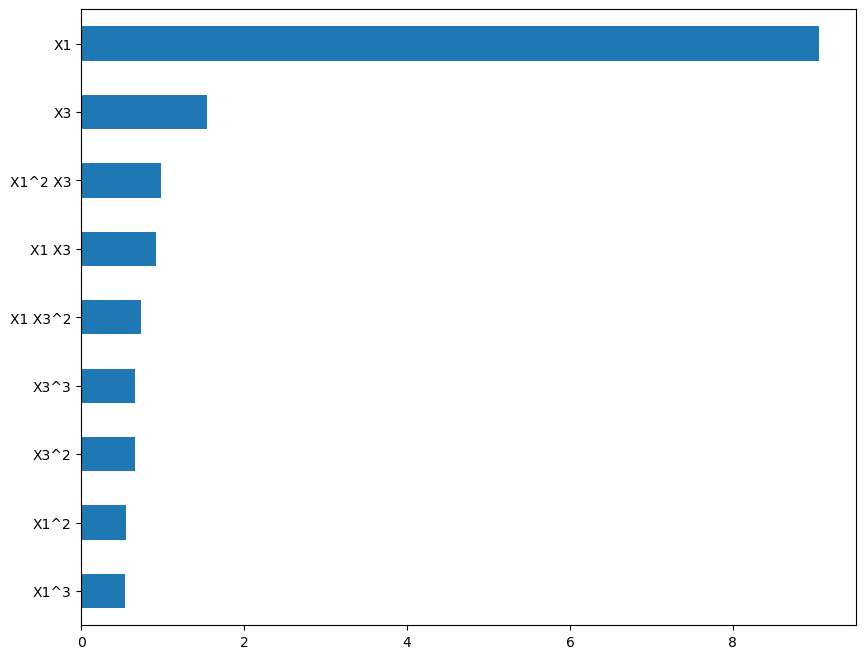

In [59]:
import pandas as pd
import numpy as np

def tailored_feature_importances(data):
    # Initialize a dictionary to store feature importances
    feature_importances = {}

    # 1. Coefficient magnitudes for Perceptron
    if 'Perceptron' in best_estimators:
        model = best_estimators['Perceptron']
        if hasattr(model, 'coef_'):
            perceptron_importances = np.abs(model.coef_).flatten()
            # Align to feature names
            perceptron_importances_aligned = pd.Series(perceptron_importances, index=model.feature_names_in_).reindex(data.columns, fill_value=0).values
            feature_importances['Perceptron'] = perceptron_importances_aligned

    # 2. Mutual Information for QuadraticDiscriminantAnalysis
    if 'QuadraticDiscriminantAnalysis' in best_estimators:
        mutual_info = mutual_info_classif(data, y_train, random_state=42)
        feature_importances['QuadraticDiscriminantAnalysis'] = mutual_info

    # 3. Centrality Measures for LabelSpreading and LabelPropagation

    if 'LabelSpreading' in best_estimators:
        try:
            centrality_scores = calculate_graph_centrality(data.values, best_estimators['LabelSpreading'], centrality_measure='eigenvector', use_dense=True)
        except TypeError:
            centrality_scores = calculate_graph_centrality(data.values, best_estimators['LabelSpreading'], centrality_measure='degree', use_dense=False)
        except Exception as e:
            raise e
        feature_importances['LabelSpreading'] = centrality_scores

    if 'LabelPropagation' in best_estimators:
        try:
            centrality_scores = calculate_graph_centrality(data.values, best_estimators['LabelPropagation'], centrality_measure='eigenvector', use_dense=True)
        except TypeError:
            centrality_scores = calculate_graph_centrality(data.values, best_estimators['LabelPropagation'], centrality_measure='degree', use_dense=False)
        except Exception as e:
            raise e
        feature_importances['LabelPropagation'] = centrality_scores

    # Convert the dictionary to a DataFrame, ensuring proper alignment
    feature_importances_df = pd.DataFrame(feature_importances, index=data.columns)

    # Summing across models
    feature_importances_df['sum'] = feature_importances_df.abs().sum(axis=1)

    return feature_importances_df

# Example usage
feature_importances_df = tailored_feature_importances(df_train_poly[selected_columns])

# Display the DataFrame
display(feature_importances_df)

# hbarplot
feature_importances_df['sum'].sort_values().plot(kind='barh', figsize=(10, 8))

(1, 4)


,QuadraticDiscriminantAnalysis,LabelSpreading,LabelPropagation,sum
X1^2 X3,0.06742,0.439873,0.439873,0.947165


<Axes: >

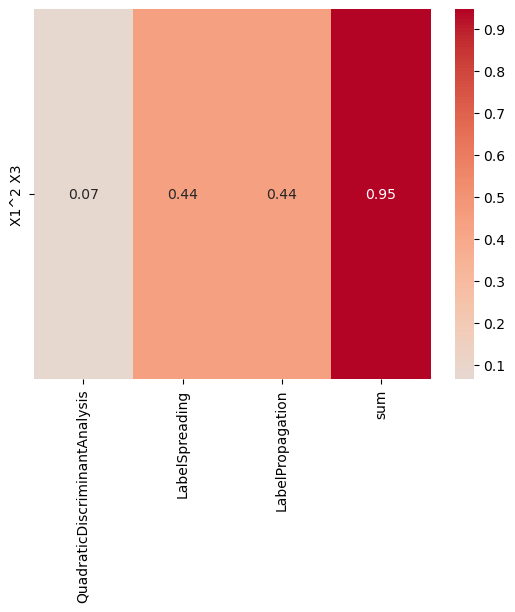

In [60]:
from sklearn.feature_selection import mutual_info_classif
import networkx as nx

# Initialize a dictionary to store feature importances
feature_importances = {}

# 1. Coefficient magnitudes for Perceptron
if 'Perceptron' in best_estimators:
    model = best_estimators['Perceptron']
    if hasattr(model, 'coef_'):
        # Ensure the coefficients length matches the polynomial features
        if model.coef_.shape[1] == len(column_names_poly):
            feature_importances['Perceptron'] = np.abs(model.coef_).flatten()

# 2. Mutual Information for QuadraticDiscriminantAnalysis
if 'QuadraticDiscriminantAnalysis' in best_estimators:
    mutual_info = mutual_info_classif(X_train_poly, y_train, random_state=42)
    feature_importances['QuadraticDiscriminantAnalysis'] = mutual_info

# 3. Centrality Measures for LabelSpreading and LabelPropagation
def calculate_graph_centrality(X_poly):
    # Creating a graph where nodes are features, and edges are similarities
    G = nx.Graph()
    G.add_nodes_from(range(X_poly.shape[1]))

    for i in range(X_poly.shape[1]):
        for j in range(i + 1, X_poly.shape[1]):
            if np.corrcoef(X_poly[:, i], X_poly[:, j])[0, 1] > 0.5:  # Adding edges with a threshold correlation
                G.add_edge(i, j, weight=np.corrcoef(X_poly[:, i], X_poly[:, j])[0, 1])

    # Calculate eigenvector centrality
    centrality = nx.eigenvector_centrality_numpy(G)
    return np.array([centrality[i] for i in range(X_poly.shape[1])])

if 'LabelSpreading' in best_estimators:
    centrality_scores = calculate_graph_centrality(X_train_poly)
    feature_importances['LabelSpreading'] = centrality_scores

if 'LabelPropagation' in best_estimators:
    centrality_scores = calculate_graph_centrality(X_train_poly)
    feature_importances['LabelPropagation'] = centrality_scores

# Convert the dictionary to a DataFrame
# Only include models with feature importances that match the polynomial features
valid_feature_importances = {
    model: importance
    for model, importance in feature_importances.items()
    if len(importance) == len(column_names_poly)
}

feature_importances_df = pd.DataFrame(valid_feature_importances, index=column_names_poly)

# Step 1: Drop features with zero importance across all models
# Keep track of the features that are non-zero in all models
non_zero_mask = pd.Series(True, index=column_names_poly)

for model, importance in feature_importances_df.items():
    non_zero_mask &= (importance >= 0.05)

# Apply the mask to keep only features with non-zero importance across all models
filtered_features_df = feature_importances_df.loc[non_zero_mask]

# Step 2: Filter by 10th percentile
# Calculate the 10th percentile for each model
quantile_thresholds = filtered_features_df.quantile(0.80)

# Keep only features that are above the 10th percentile for at least one model
quantile_mask = pd.Series(False, index=filtered_features_df.index)

for model in filtered_features_df.columns:
    quantile_mask |= (filtered_features_df[model] >= quantile_thresholds[model])

# Apply the mask to keep only features in the top 30% importance for at least one model
final_filtered_features_df = filtered_features_df.loc[quantile_mask]

# Sum across models
final_filtered_features_df['sum'] = final_filtered_features_df.iloc[:, :3].abs().sum(axis=1)

print(final_filtered_features_df.shape)

# Display the DataFrame
_ = final_filtered_features_df.sort_values('sum', ascending=False)
display(_)
# Heatmap
sns.heatmap(final_filtered_features_df, cmap='coolwarm', center=0, annot=True, fmt=".2f")

In [61]:
valid_feature_importances

{'QuadraticDiscriminantAnalysis': array([0.        , 0.        , 0.03575669, 0.        , 0.00113028,
        0.0159849 , 0.06741952, 0.        , 0.        ]),
 'LabelSpreading': array([0.24070221, 0.33136522, 0.24070221, 0.43987255, 0.33136522,
        0.24070221, 0.43987255, 0.33136522, 0.33136522]),
 'LabelPropagation': array([0.24070221, 0.33136522, 0.24070221, 0.43987255, 0.33136522,
        0.24070221, 0.43987255, 0.33136522, 0.33136522])}

The analysis highlights **X1** and **X3** as critical questions to include in future surveys, with potential non-linear effects and significant interactions influencing customer happiness.

## Selecting the Questions

1. **Understand the Combinations**: The feature combinations listed represent interactions or selections of different features. For example, `X1^2 X3` suggests an interaction or squared term involving `X1` and `X3`.

2. **Sum Scores**: The sum column indicates the combined importance across all models for each feature set. The higher the sum, the more predictive that feature set is deemed.

3. **Top Feature Combinations**:
   - The highest scoring combination is `X1^2 X3` with a sum of `0.4148`.
   - This suggests that the interaction between `X1` ("My order was delivered on time") and `X3` ("I ordered everything I wanted to order"), particularly with `X1` squared, is the most predictive of customer happiness.

### Insights:

- **Most Important Features**: 
   - **X1 (Order Delivery Time)** and **X3 (Order Completeness)** appear frequently in the top combinations. This suggests that these two features are critical in predicting customer happiness.
   - The importance of `X1^2` suggests that the effect of delivery time on happiness might be non-linear (e.g., being very early or very late could have a different impact).

- **Features That Could Be Removed**:
   - **X6 (App usability)** appears less frequently in top combinations, especially when not interacting with others, which might suggest it’s less critical on its own.
   - **X2 (Contents as Expected)** and **X4 (Price Satisfaction)** also show up but are not consistently top contributors without interactions with other variables.

### Recommendations:

1. **Focus on Key Features**:
   - Keep questions related to **X1 (Order Delivery Time)** and **X3 (Order Completeness)**, as they consistently appear as the most important predictors.
   - Consider retaining **X5 (Courier Satisfaction)** and **X2 (Contents Satisfaction)** as they contribute through interactions.

2. **Potential Removal**:
   - You might consider removing or re-evaluating **X6 (App Usability)** unless it is critical for strategic reasons beyond this model.

In [62]:
feature_importances_df.assign(sum=lambda x: x.abs().sum(axis=1)).nlargest(10, 'sum')

,QuadraticDiscriminantAnalysis,LabelSpreading,LabelPropagation,sum
X1^2 X3,0.067420,0.439873,0.439873,0.947165
X1 X3,0.000000,0.439873,0.439873,0.879745
X3^2,0.001130,0.331365,0.331365,0.663861
X3^3,0.000000,0.331365,0.331365,0.662730
X3,0.000000,0.331365,0.331365,0.662730
X1 X3^2,0.000000,0.331365,0.331365,0.662730
X1^2,0.035757,0.240702,0.240702,0.517161
X1^3,0.015985,0.240702,0.240702,0.497389
X1,0.000000,0.240702,0.240702,0.481404


In [63]:
#use lazypredict to check new variables
from lazypredict import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=recall_score)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

if 'meta_scores' not in locals():
    meta_scores = {}
meta_scores[''.join(use_columns).replace("Y", "")] = models.sort_values('recall_score', ascending=False)

 97%|█████████▋| 30/31 [00:01<00:00, 20.42it/s]  File "c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
100%|██████████| 31/31 [00:01<00:00, 18.85it/s]

[LightGBM] [Info] Number of positive: 58, number of negative: 42
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.580000 -> initscore=0.322773
[LightGBM] [Info] Start training from score 0.322773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_recall_score_distribution(meta_scores):
    plt.figure(figsize=(12, 8))

    for key in sorted(meta_scores.keys()):
        df = meta_scores[key]
        sns.kdeplot(df['recall_score'], label=key, fill=True, alpha=.08)

    plt.title('Distribution of Recall Score Across Different Models')
    plt.xlabel('Recall Score')
    plt.ylabel('Density')
    plt.legend(title='Model')
    plt.show()

# Example usage:
plot_recall_score_distribution(meta_scores)

TypeError: string indices must be integers

<Figure size 1200x800 with 0 Axes>

# Store transformations

In [ ]:
# add the target to the data df_train_poly
# df_selected = df_train_poly[final_filtered_features_df.index].assign(Y = y_train)
# df_selected = df_test_poly[final_filtered_features_df.index].assign(Y = y_test)

df_selected = df_train_poly.assign(Y = y_train)
df_selected = df_test_poly.assign(Y = y_test)

# # Export the feature engeneered data to parquet
df_selected.to_parquet('../data/clean/train-simplified.parquet')
df_selected.to_parquet('../data/clean/test-simplified.parquet')


import json

# score for Combinations
dict_combinations = {k:v.to_json() for k,v in meta_scores.items()}

# Write to JSON file
with open("../data/scores_combinations.json", "w") as write_file:
    json.dump(dict_combinations, write_file)

In [97]:
meta_scores['X1X3'].loc[: , ['recall_score', 'F1 Score', 'ROC AUC', 'Balanced Accuracy', 'Time Taken']]

# Create model score column as (2*recall_score+F1 Score+ROC AUC+ 1/2 Balanced Accuracy) / log (10*Time Taken)
meta_scores['X1X3']['Model Score'] = (3*meta_scores['X1X3']['recall_score'] + 1.4*meta_scores['X1X3']['F1 Score'] + 2.1*meta_scores['X1X3']['ROC AUC'] + 0.5*meta_scores['X1X3']['Balanced Accuracy']) / 15*np.sqrt(meta_scores['X1X3']['Time Taken'])
# Sort the models by Model Score
meta_scores['X1X3'].nlargest(7, 'Model Score')

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,recall_score,Time Taken,Model Score
Model,,,,,,,
XGBClassifier,0.50,0.54,0.54,0.47,0.82,0.30,0.16
LGBMClassifier,0.62,0.62,0.62,0.62,0.64,0.21,0.13
RandomForestClassifier,0.54,0.58,0.58,0.52,0.82,0.18,0.13
ExtraTreesClassifier,0.54,0.58,0.58,0.52,0.82,0.14,0.12
AdaBoostClassifier,0.54,0.55,0.55,0.54,0.64,0.16,0.11
BaggingClassifier,0.54,0.58,0.58,0.52,0.82,0.05,0.07
BernoulliNB,0.62,0.62,0.62,0.62,0.64,0.05,0.07
